In [41]:
import mat73
import pandas as pd
import numpy as np
import scipy.io
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

### Data loading and preprocessing

In [42]:
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()) and "anuja" in os.environ.get('USER'):
    DATA_DIR = 'data/'
    

In [43]:
foof = pd.read_csv(DATA_DIR+"foof2features.csv")
foof = foof.rename(columns={"C1": "IDs" ,"C2": "Intercept", "C3": "Slope"})
foof

,IDs,Intercept,Slope
0,NDARAA075AMK,0.986272,1.825774
1,NDARAA112DMH,1.486650,1.888544
2,NDARAA117NEJ,1.593155,2.095749
3,NDARAA947ZG5,0.703331,1.724831
4,NDARAA948VFH,0.918020,1.749441
...,...,...,...
2037,NDARZN277NR6,1.351549,1.996940
2038,NDARZN578YDP,1.380795,2.036327
2039,NDARZN610GTY,0.339229,1.050644
2040,NDARZN677EYE,0.781225,1.470061


In [44]:
data = scipy.io.loadmat(DATA_DIR+'x.mat')  
df = pd.DataFrame(data['x'].reshape((data['x'].shape[0], -1)))

# sparsing
df = np.array(df).reshape(data['x'].shape)
df_sparsed = np.concatenate([np.expand_dims(df[:,:,i:i+2].mean(axis = 2), axis = 2) for i in range(0, data['x'].shape[2]-2, 2)], axis = 2)
df = pd.DataFrame(df_sparsed.reshape((df_sparsed.shape[0], -1)))

#scaling
norm = MinMaxScaler().fit(df)
df = norm.transform(df)
df = pd.DataFrame(df.reshape((df.shape[0], -1)))

columns = np.asarray([['Electrode %d - %d/2 Hz'%(i+1, j+1)] for i in range(df_sparsed.shape[1]) for j in range(df_sparsed.shape[2])])
df.columns = columns
df['IDs'] = foof['IDs']
df

,"(Electrode 1 - 1/2 Hz,)","(Electrode 1 - 2/2 Hz,)","(Electrode 1 - 3/2 Hz,)","(Electrode 1 - 4/2 Hz,)","(Electrode 1 - 5/2 Hz,)","(Electrode 1 - 6/2 Hz,)","(Electrode 1 - 7/2 Hz,)","(Electrode 1 - 8/2 Hz,)","(Electrode 1 - 9/2 Hz,)","(Electrode 1 - 10/2 Hz,)",...,"(Electrode 105 - 31/2 Hz,)","(Electrode 105 - 32/2 Hz,)","(Electrode 105 - 33/2 Hz,)","(Electrode 105 - 34/2 Hz,)","(Electrode 105 - 35/2 Hz,)","(Electrode 105 - 36/2 Hz,)","(Electrode 105 - 37/2 Hz,)","(Electrode 105 - 38/2 Hz,)","(Electrode 105 - 39/2 Hz,)",IDs
0,1.212006e-10,2.857691e-08,0.000006,0.001066,0.033290,0.143816,0.221608,0.467715,0.593581,0.401686,...,0.000007,0.000002,4.333844e-07,9.373567e-08,1.616373e-08,3.256580e-09,4.986456e-10,7.457518e-11,1.130004e-11,NDARAA075AMK
1,1.539866e-01,3.856645e-01,0.074284,0.216988,0.177267,0.161251,0.117761,0.132384,0.049898,0.004720,...,0.031636,0.009416,2.352137e-03,4.122513e-04,4.825197e-05,5.944433e-06,5.749150e-07,6.398086e-08,8.415637e-09,NDARAA112DMH
2,3.439263e-05,4.110931e-03,0.094118,0.367821,0.284890,0.164614,0.216934,0.333176,0.526883,0.511715,...,0.000311,0.000079,2.045964e-05,4.443460e-06,7.491343e-07,1.436770e-07,2.039047e-08,2.751924e-09,3.663748e-10,NDARAA117NEJ
3,2.832192e-01,3.613309e-01,0.378969,0.299813,0.247412,0.058588,0.015256,0.004514,0.003988,0.061608,...,0.158691,0.150551,1.580043e-01,1.518115e-01,1.233778e-01,1.242931e-01,1.009636e-01,8.498748e-02,7.690149e-02,NDARAA947ZG5
4,1.247342e-04,1.132987e-02,0.167700,0.368840,0.155464,0.104191,0.194459,0.288490,0.233210,0.125520,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NDARAA948VFH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,2.303407e-04,2.867255e-02,0.194945,0.081646,0.018422,0.076959,0.179779,0.300051,0.417245,0.459853,...,0.093399,0.058729,4.012462e-02,2.464919e-02,1.257993e-02,7.816617e-03,3.846395e-03,1.926406e-03,1.018633e-03,NDARZN277NR6
2038,1.385606e-02,2.124126e-02,0.032991,0.043456,0.048827,0.049759,0.074988,0.222227,0.444972,0.464653,...,0.016832,0.009602,5.877454e-03,3.190797e-03,1.418509e-03,7.564419e-04,3.146594e-04,1.311957e-04,5.687030e-05,NDARZN578YDP
2039,1.089647e-02,3.749309e-02,0.139003,0.289797,0.304728,0.196113,0.191950,0.342653,0.413368,0.344024,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NDARZN610GTY
2040,6.411911e-03,2.687961e-02,0.095551,0.241121,0.434011,0.574767,0.694741,0.815939,0.678021,0.490314,...,0.059230,0.026090,1.169173e-02,4.410850e-03,1.294309e-03,4.329110e-04,1.073561e-04,2.536768e-05,5.924775e-06,NDARZN677EYE


In [45]:
beh = pd.read_csv(DATA_DIR+"behaviorals.csv")
print('Before:'+str(beh.shape))

most_common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders',  'No Diagnosis Given', 'Other Disorders']

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)] +\
                   ['DX_' + str(i).zfill(2) + '_Sub' for i in range(1, 11)]

# removing patients with incomplete eval
initial_size = beh.shape[0]
beh = beh[beh.DX_01 != 'No Diagnosis Given: Incomplete Eval']
beh = beh.reset_index(drop=True)
new_size = beh.shape[0]

print('After:'+str(beh.shape))
print('Removing', initial_size - new_size,
      'patients as their evaluations was incomplete.')

Before:(3076, 177)
After:(2939, 177)
Removing 137 patients as their evaluations was incomplete.


In [46]:
no_diagnosis_given = 'No Diagnosis Given'

diagnoses_to_ids = {disorder: i for i, disorder in enumerate(most_common_disorders)}
diagnoses_to_ids

{'Attention-Deficit/Hyperactivity Disorder': 0,
 'Anxiety Disorders': 1,
 'Specific Learning Disorder': 2,
 'Autism Spectrum Disorder': 3,
 'Disruptive': 4,
 'Communication Disorder': 5,
 'Depressive Disorders': 6,
 'No Diagnosis Given': 7,
 'Other Disorders': 8}

In [47]:
def get_disorder(data, row, index):
    disorder = data.iloc[row][category_columns[index]]

    if disorder == 'Neurodevelopmental Disorders':
        disorder = data.iloc[row][category_columns[index + 10]]

    return disorder

order_of_disorders = []
for k in range(beh.shape[0]):
    i = 0
    disorder = get_disorder(beh, k, i)
    disorders_patient = []
    while not pd.isnull(disorder):
        if disorder in diagnoses_to_ids:
            if diagnoses_to_ids[disorder] not in disorders_patient:
                disorders_patient.append(diagnoses_to_ids[disorder])
        else:
            if diagnoses_to_ids['Other Disorders'] not in disorders_patient:
                disorders_patient.append(diagnoses_to_ids['Other Disorders'])
        i += 1
        if i == len(category_columns):
            break
        disorder = get_disorder(beh, k, i)

        
    order_of_disorders.append(disorders_patient)

In [48]:
other_disorders = []
no_diagnosis_given = []
for i in order_of_disorders:
    if 7 in i:
        no_diagnosis_given.append(1)
        i.remove(7)
    else:
        no_diagnosis_given.append(0)
    if 8 in i:
        other_disorders.append(1)
        i.remove(8)
    else:
        other_disorders.append(0)

In [49]:
max_len_order = np.max([len(x) for x in order_of_disorders])

# pad with a new token denoting the pad token
pad_token = len(most_common_disorders)
bod_token = len(most_common_disorders) + 1
eod_token = len(most_common_disorders) + 2

order_of_disorders = [[bod_token] + x + [eod_token] + [pad_token] * (max_len_order - len(x)) for x in order_of_disorders]

order_of_disorders = np.array(order_of_disorders)

classes = np.zeros((len(most_common_disorders),
                    beh.shape[0]), dtype=np.int32)

df_disorders = beh[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
        applymap(lambda x: disorder in x if pd.notnull(x) else False)

    disorder_df = df_disorders[mask.any(axis=1)]

    np.add.at(classes[i], disorder_df.index.values, 1)

behaviour_data_columns = beh.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX') != -1)]

behaviour_data = beh.drop(columns=columns_to_drop)

for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

behaviour_data['order_diagnoses'] = list(order_of_disorders)

In [50]:
common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders']

labels=behaviour_data[["IDs"]+list(common_disorders)]
labels["Other Disorders"] = other_disorders
labels

/tmp/ipykernel_1159764/226828375.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels["Other Disorders"] = other_disorders


,IDs,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,Communication Disorder,Depressive Disorders,Other Disorders
0,NDARAA075AMK,0,0,0,0,0,0,0,0
1,NDARAA112DMH,1,0,0,0,1,0,0,1
2,NDARAA117NEJ,1,0,0,0,1,0,0,1
3,NDARAA306NT2,1,1,1,0,0,1,0,1
4,NDARAA504CRN,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
2934,NDARZZ007YMP,0,0,0,1,0,0,0,1
2935,NDARZZ740MLM,1,0,0,0,0,0,0,0
2936,NDARZZ810LVF,0,0,0,1,0,1,0,1
2937,NDARZZ830JM7,0,0,0,1,0,0,0,1


In [51]:
df = pd.merge(df, foof, on='IDs', how='inner')
df = pd.merge(df, labels, on='IDs', how='inner')
df

,"(Electrode 1 - 1/2 Hz,)","(Electrode 1 - 2/2 Hz,)","(Electrode 1 - 3/2 Hz,)","(Electrode 1 - 4/2 Hz,)","(Electrode 1 - 5/2 Hz,)","(Electrode 1 - 6/2 Hz,)","(Electrode 1 - 7/2 Hz,)","(Electrode 1 - 8/2 Hz,)","(Electrode 1 - 9/2 Hz,)","(Electrode 1 - 10/2 Hz,)",...,Intercept,Slope,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,Communication Disorder,Depressive Disorders,Other Disorders
0,1.212006e-10,2.857691e-08,0.000006,0.001066,0.033290,0.143816,0.221608,0.467715,0.593581,0.401686,...,0.986272,1.825774,0,0,0,0,0,0,0,0
1,1.539866e-01,3.856645e-01,0.074284,0.216988,0.177267,0.161251,0.117761,0.132384,0.049898,0.004720,...,1.486650,1.888544,1,0,0,0,1,0,0,1
2,3.439263e-05,4.110931e-03,0.094118,0.367821,0.284890,0.164614,0.216934,0.333176,0.526883,0.511715,...,1.593155,2.095749,1,0,0,0,1,0,0,1
3,2.832192e-01,3.613309e-01,0.378969,0.299813,0.247412,0.058588,0.015256,0.004514,0.003988,0.061608,...,0.703331,1.724831,1,0,1,1,0,0,0,1
4,1.247342e-04,1.132987e-02,0.167700,0.368840,0.155464,0.104191,0.194459,0.288490,0.233210,0.125520,...,0.918020,1.749441,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916,1.556547e-05,2.900630e-04,0.003548,0.023882,0.088943,0.189421,0.293481,0.445277,0.644915,0.577096,...,0.168009,0.205704,0,1,0,0,0,0,0,0
1917,2.303407e-04,2.867255e-02,0.194945,0.081646,0.018422,0.076959,0.179779,0.300051,0.417245,0.459853,...,1.351549,1.996940,1,1,0,0,0,0,1,0
1918,1.089647e-02,3.749309e-02,0.139003,0.289797,0.304728,0.196113,0.191950,0.342653,0.413368,0.344024,...,0.339229,1.050644,0,0,0,0,0,0,0,1
1919,6.411911e-03,2.687961e-02,0.095551,0.241121,0.434011,0.574767,0.694741,0.815939,0.678021,0.490314,...,0.781225,1.470061,1,0,0,0,0,0,0,0


### Data Split

In [52]:
disorders_list = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders', 'Other Disorders']
x = df[df.columns.difference(['IDs']+disorders_list)]
y = df[disorders_list]

# summarize dataset shape
print(x.shape, y.shape)

(1921, 4097) (1921, 8)


## SHUFFLING

In [78]:
#RUN this only if you want to have the dummy baseline!
x = x.sample(frac=1).reset_index(drop=True)

In [79]:
train_features, test_features, train_labels, test_labels = train_test_split(x, y, test_size=0.25, shuffle=True)

In [55]:
train_labels = np. array(train_labels) 
test_labels = np. array(test_labels) 

In [56]:
print(train_features.shape, test_features.shape)

(1440, 4097) (481, 4097)


## FEATURE EXTRACTION WITH PCA

In [76]:
#scaling features

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(train_features)

# transform training data
train_features = norm.transform(train_features)
test_features = norm.transform(test_features)

print(train_features.shape, test_features.shape)

(1440, 219) (481, 219)


In [77]:
# dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(.95) # 95% variance retained
pca.fit(train_features)

# transform data
train_features = pca.transform(train_features)
test_features = pca.transform(test_features)
print(train_features.shape, test_features.shape)

(1440, 199) (481, 199)


## FEATURE EXTRACTION WITH AUTOENCODER

In [59]:
# import tensorflow as tf
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
# from tensorflow.keras.utils import plot_model, to_categorical

# n_inputs = train_features.shape[1]

# visible = Input(shape=(n_inputs,))
# e = Dense(n_inputs*2)(visible)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# e = Dense(n_inputs)(e)
# e = BatchNormalization()(e)
# e = LeakyReLU()(e)
# n_bottleneck = round(float(n_inputs) / 2.0)
# bottleneck = Dense(n_bottleneck)(e)

# d = Dense(n_inputs)(bottleneck)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)

# d = Dense(n_inputs*2)(d)
# d = BatchNormalization()(d)
# d = LeakyReLU()(d)

# output = Dense(8, activation='linear')(d)

# model = Model(inputs=visible, outputs=output)
# model.compile(optimizer='adam', loss='mse')
# plot_model(model, 'autoencoder_compress.png', show_shapes=True)

# history = model.fit(train_features, train_labels, epochs=50, batch_size=16, verbose=2)
# encoder = Model(inputs=visible, outputs=bottleneck)

# plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# encoder.save('autoencoder.h5')

In [60]:
# # encode the data
# encoder= load_model('autoencoder.h5', compile=False)

# train_features = encoder.predict(train_features)
# test_features = encoder.predict(test_features)

### Metrics

In [61]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

n_classes = train_labels.shape[1]

def plot_pr_curve(Y_test, y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        Y_test.ravel(), y_score.ravel()
    )
    average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

    _, ax = plt.subplots(figsize=(8, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i in range(n_classes):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}")

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Precision-Recall curve")

    plt.show()
    
def plot_roc_curve(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
   
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [62]:
from sklearn.metrics import hamming_loss, accuracy_score
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))

def evaluate(y_test, y_pred_prob, brier=True):
    y_pred = y_pred_prob.round()
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Hamming Loss:", hamming_loss(y_test, y_pred))
    if brier:
        print("Brier Score:", brier_multi(y_test, y_pred_prob))
    print("Classification Report:\n", skm.classification_report(y_test,y_pred, zero_division=1))
    print("Confusion matrix:\n", skm.multilabel_confusion_matrix(y_test, y_pred))

## Models

### Multi Output Classifier

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

LogisticRegression():
Accuracy: 0.09147609147609148
Hamming Loss: 0.2609147609147609
Brier Score: 1.4509897891294026
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.73      0.68       294
           1       0.37      0.21      0.27       163
           2       0.19      0.05      0.08       103
           3       0.31      0.05      0.09        73
           4       0.18      0.05      0.07        65
           5       0.24      0.06      0.09        72
           6       0.23      0.07      0.10        45
           7       0.40      0.31      0.35       182

   micro avg       0.49      0.33      0.39       997
   macro avg       0.32      0.19      0.22       997
weighted avg       0.40      0.33      0.34       997
 samples avg       0.59      0.43      0.35       997

Confusion matrix:
 [[[ 63 124]
  [ 78 216]]

 [[260  58]
  [129  34]]

 [[357  21]
  [ 98   5]]

 [[399   9]
  [ 69   4]]

 [[402  14]
  [ 62   3]]

 [[39

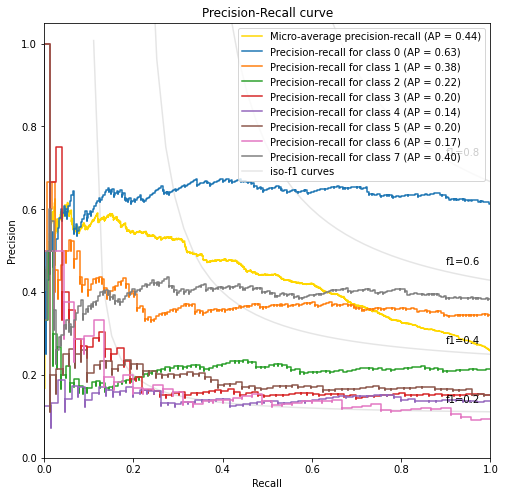

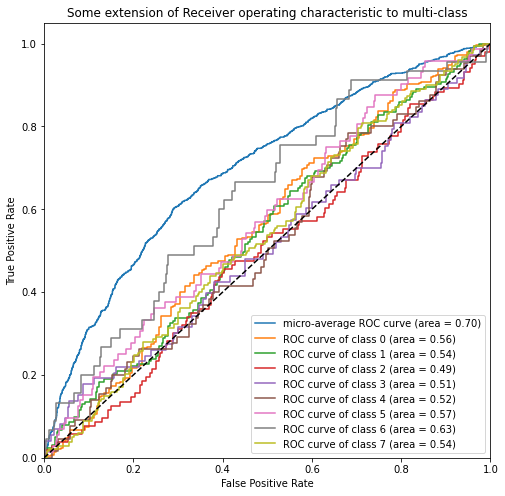

RandomForestClassifier(random_state=1):
Accuracy: 0.12058212058212059
Hamming Loss: 0.23648648648648649
Brier Score: 1.360054054054054
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.94      0.74       294
           1       0.20      0.01      0.01       163
           2       0.00      0.00      0.00       103
           3       1.00      0.00      0.00        73
           4       1.00      0.00      0.00        65
           5       1.00      0.00      0.00        72
           6       1.00      0.00      0.00        45
           7       0.33      0.06      0.10       182

   micro avg       0.59      0.29      0.39       997
   macro avg       0.64      0.13      0.11       997
weighted avg       0.53      0.29      0.24       997
 samples avg       0.62      0.42      0.37       997

Confusion matrix:
 [[[ 13 174]
  [ 18 276]]

 [[314   4]
  [162   1]]

 [[377   1]
  [103   0]]

 [[408   0]
  [ 73   0]]

 [[416   0]
 

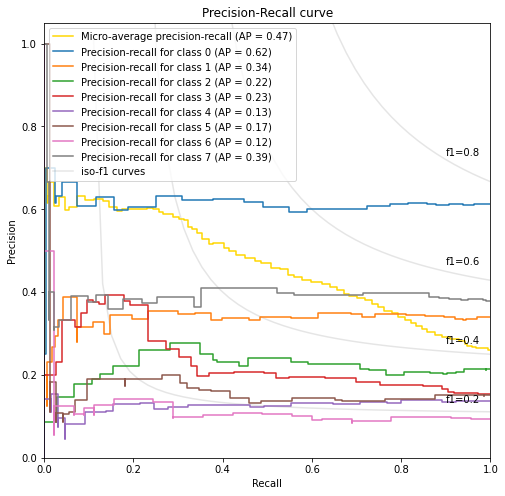

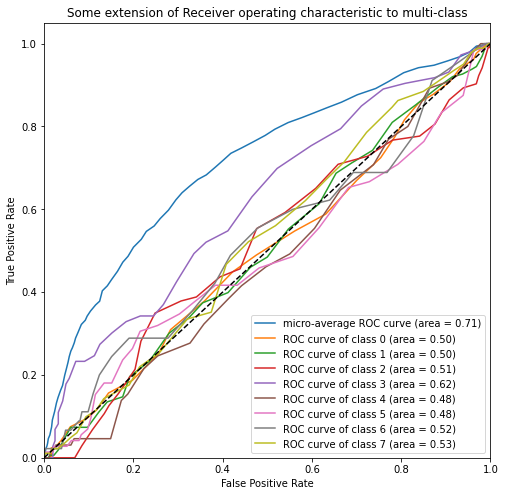

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
forest = RandomForestClassifier(random_state=1)
lg = LogisticRegression()
models = [lg, forest]

for model in models:

    multi_output_model = MultiOutputClassifier(model, n_jobs=-1)
    multi_output_model.fit(train_features, train_labels)
    predicted_labels = np.asarray(multi_output_model.predict_proba(test_features))[:, :, 1].T
    print(str(model)+':')
    evaluate(test_labels, predicted_labels)
    plot_pr_curve(test_labels, predicted_labels)
    plot_roc_curve(test_labels, predicted_labels)

## MLP SIMPLE

Epoch 1/100
45/45 [==============================] - 0s 1ms/step - loss: 0.6684
Epoch 2/100
45/45 [==============================] - 0s 973us/step - loss: 0.5447
Epoch 3/100
45/45 [==============================] - 0s 979us/step - loss: 0.5131
Epoch 4/100
45/45 [==============================] - 0s 950us/step - loss: 0.4979
Epoch 5/100
45/45 [==============================] - 0s 946us/step - loss: 0.4861
Epoch 6/100
45/45 [==============================] - 0s 954us/step - loss: 0.4755
Epoch 7/100
45/45 [==============================] - 0s 980us/step - loss: 0.4662
Epoch 8/100
45/45 [==============================] - 0s 965us/step - loss: 0.4566
Epoch 9/100
45/45 [==============================] - 0s 956us/step - loss: 0.4478
Epoch 10/100
45/45 [==============================] - 0s 967us/step - loss: 0.4392
Epoch 11/100
45/45 [==============================] - 0s 959us/step - loss: 0.4308
Epoch 12/100
45/45 [==============================] - 0s 953us/step - loss: 0.4220
Epoch 13/100
45

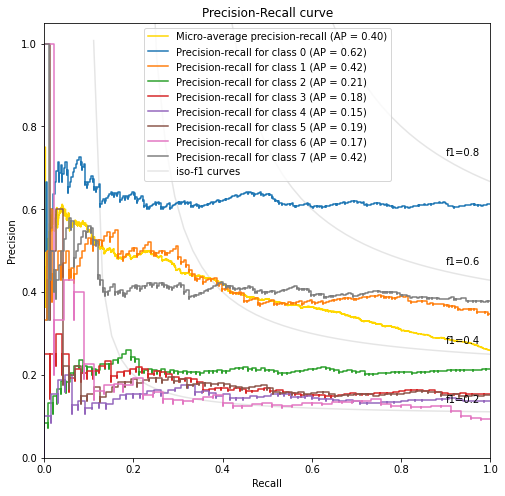

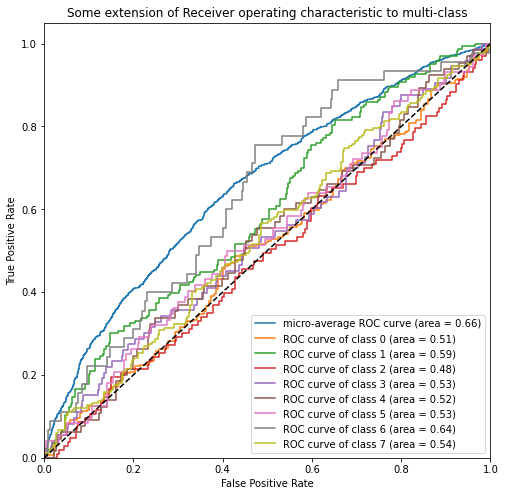

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
mlp = get_mlp(n_inputs, n_outputs)
mlp.fit(train_features, train_labels, verbose=1, epochs=100)

predicted_labels_mlp = mlp.predict(test_features)
evaluate(test_labels, predicted_labels_mlp)

plot_pr_curve(test_labels, predicted_labels_mlp)
plot_roc_curve(test_labels, predicted_labels_mlp)

## MLP complex

Epoch 1/100
45/45 [==============================] - 0s 1ms/step - loss: 0.7682
Epoch 2/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5753
Epoch 3/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5227
Epoch 4/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5094
Epoch 5/100
45/45 [==============================] - 0s 1ms/step - loss: 0.5011
Epoch 6/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4938
Epoch 7/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4869
Epoch 8/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4801
Epoch 9/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4721
Epoch 10/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4643
Epoch 11/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4563
Epoch 12/100
45/45 [==============================] - 0s 1ms/step - loss: 0.4474
Epoch 13/100
45/45 [=================

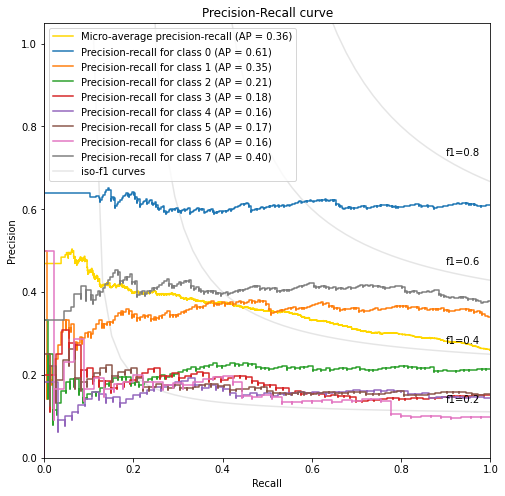

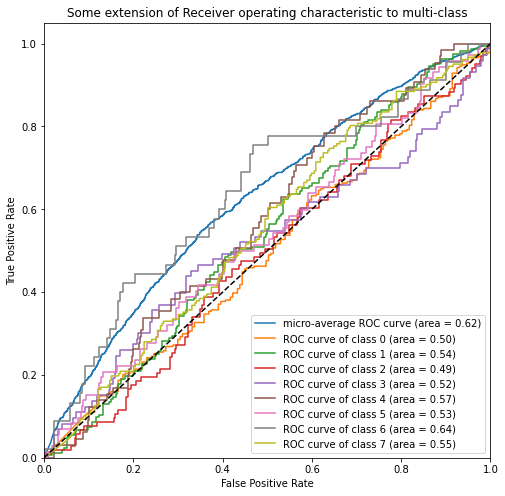

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))

    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
mlp = get_mlp(n_inputs, n_outputs)
mlp.fit(train_features, train_labels, verbose=1, epochs=100)

predicted_labels_mlp = mlp.predict(test_features)
evaluate(test_labels, predicted_labels_mlp)

plot_pr_curve(test_labels, predicted_labels_mlp)
plot_roc_curve(test_labels, predicted_labels_mlp)

### Binary Relevance
ignores the possible correlations between class labels

In [66]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

classifier = BinaryRelevance(GaussianNB())
classifier.fit(train_features, train_labels)

BinaryRelevance(classifier=GaussianNB(), require_dense=[True, True])

In [67]:
predicted_labels_br = classifier.predict_proba(test_features)
evaluate(test_labels, predicted_labels_br.toarray())

Accuracy: 0.09147609147609148
Hamming Loss: 0.2746881496881497
Brier Score: 1.7103527259024685
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.76      0.70       294
           1       0.29      0.14      0.19       163
           2       0.24      0.09      0.13       103
           3       0.26      0.14      0.18        73
           4       0.12      0.05      0.07        65
           5       0.10      0.04      0.06        72
           6       0.18      0.16      0.17        45
           7       0.41      0.25      0.31       182

   micro avg       0.46      0.32      0.38       997
   macro avg       0.28      0.20      0.22       997
weighted avg       0.38      0.32      0.34       997
 samples avg       0.60      0.43      0.35       997

Confusion matrix:
 [[[ 65 122]
  [ 72 222]]

 [[262  56]
  [140  23]]

 [[350  28]
  [ 94   9]]

 [[379  29]
  [ 63  10]]

 [[393  23]
  [ 62   3]]

 [[381  28]
  [ 69   3]]

 

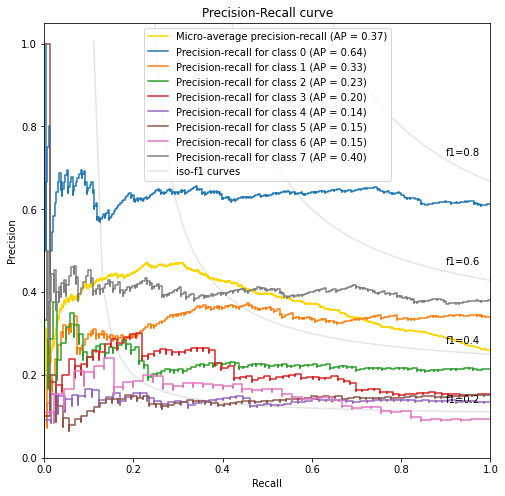

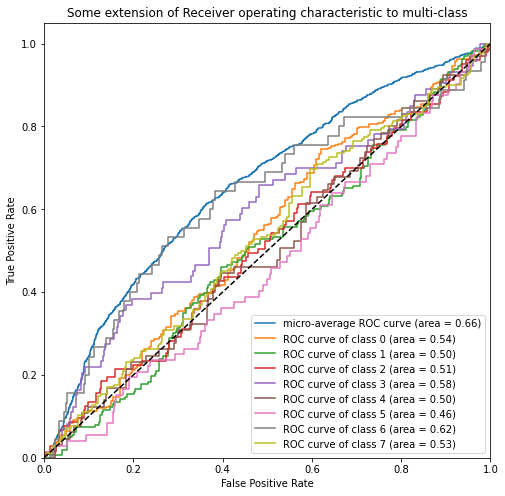

In [68]:
plot_pr_curve(test_labels, predicted_labels_br.toarray())
plot_roc_curve(test_labels, predicted_labels_br.toarray())

### Classfier Chains

In [69]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

classifier = ClassifierChain(LogisticRegression())
classifier.fit(train_features, train_labels)
# we should optimise this a little

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

ClassifierChain(classifier=LogisticRegression(), require_dense=[True, True])

In [70]:
predicted_labels_cc = classifier.predict_proba(test_features)
evaluate(test_labels, predicted_labels_cc.toarray())

Accuracy: 0.0997920997920998
Hamming Loss: 0.2603950103950104
Brier Score: 1.4872138443754492
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.73      0.68       294
           1       0.37      0.21      0.27       163
           2       0.20      0.05      0.08       103
           3       0.33      0.08      0.13        73
           4       0.18      0.11      0.14        65
           5       0.27      0.04      0.07        72
           6       0.33      0.11      0.17        45
           7       0.41      0.21      0.28       182

   micro avg       0.50      0.31      0.39       997
   macro avg       0.34      0.19      0.23       997
weighted avg       0.41      0.31      0.33       997
 samples avg       0.62      0.41      0.34       997

Confusion matrix:
 [[[ 63 124]
  [ 78 216]]

 [[259  59]
  [129  34]]

 [[358  20]
  [ 98   5]]

 [[396  12]
  [ 67   6]]

 [[385  31]
  [ 58   7]]

 [[401   8]
  [ 69   3]]

 [

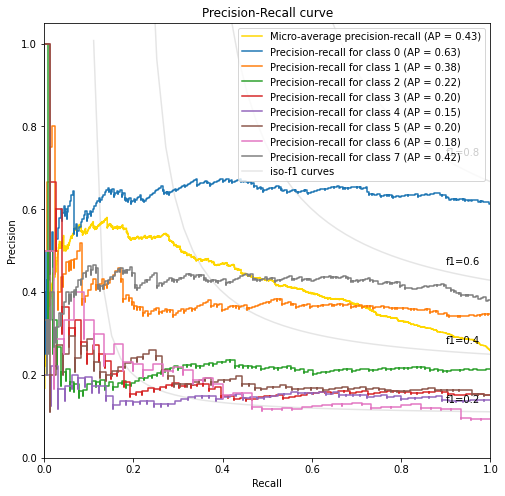

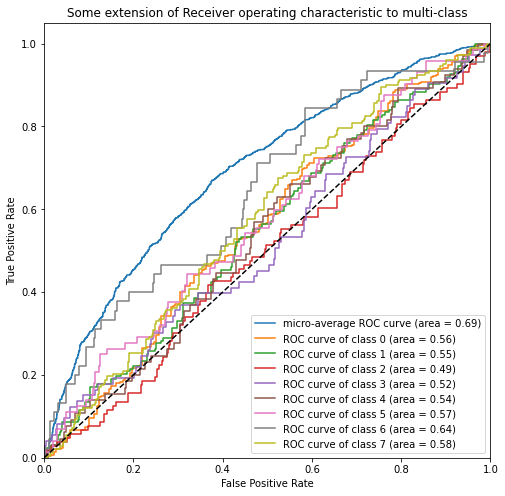

In [71]:
plot_pr_curve(test_labels, predicted_labels_cc.toarray())
plot_roc_curve(test_labels, predicted_labels_cc.toarray())

### Label Powerset
takes correlations into account!

In [72]:
from skmultilearn.problem_transform import LabelPowerset

classifier = LabelPowerset(LogisticRegression())
classifier.fit(train_features, train_labels)

/home/ubuntu/anaconda3/envs/ai4halth/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LabelPowerset(classifier=LogisticRegression(), require_dense=[True, True])

In [73]:
predicted_labels_lp = classifier.predict_proba(test_features)
evaluate(test_labels, predicted_labels_lp.toarray())

Accuracy: 0.0997920997920998
Hamming Loss: 0.2494802494802495
Brier Score: 1.4340007218586195
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.73      0.67       294
           1       0.43      0.20      0.27       163
           2       0.11      0.01      0.02       103
           3       0.29      0.03      0.05        73
           4       0.25      0.03      0.05        65
           5       0.00      0.00      0.00        72
           6       0.00      0.00      0.00        45
           7       0.41      0.24      0.30       182

   micro avg       0.53      0.30      0.38       997
   macro avg       0.26      0.15      0.17       997
weighted avg       0.38      0.30      0.31       997
 samples avg       0.63      0.40      0.34       997

Confusion matrix:
 [[[ 57 130]
  [ 80 214]]

 [[274  44]
  [130  33]]

 [[370   8]
  [102   1]]

 [[403   5]
  [ 71   2]]

 [[410   6]
  [ 63   2]]

 [[407   2]
  [ 72   0]]

 [

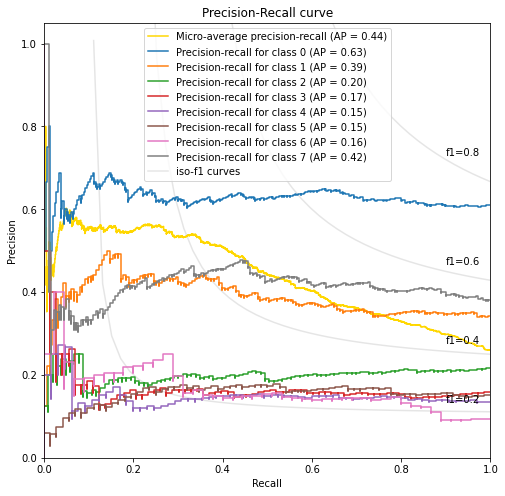

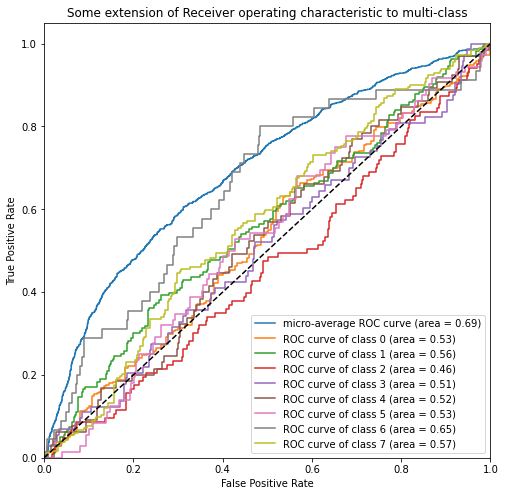

In [74]:
plot_pr_curve(test_labels, predicted_labels_lp.toarray())
plot_roc_curve(test_labels, predicted_labels_lp.toarray())

Accuracy: 0.12266112266112267
Hamming Loss: 0.23154885654885654
Brier Score: 1.3381276507276505
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.98      0.75       294
           1       1.00      0.00      0.00       163
           2       1.00      0.00      0.00       103
           3       1.00      0.00      0.00        73
           4       1.00      0.00      0.00        65
           5       1.00      0.00      0.00        72
           6       1.00      0.00      0.00        45
           7       0.50      0.05      0.10       182

   micro avg       0.61      0.30      0.40       997
   macro avg       0.89      0.13      0.11       997
weighted avg       0.79      0.30      0.24       997
 samples avg       0.62      0.42      0.38       997

Confusion matrix:
 [[[  5 182]
  [  6 288]]

 [[318   0]
  [163   0]]

 [[378   0]
  [103   0]]

 [[408   0]
  [ 73   0]]

 [[416   0]
  [ 65   0]]

 [[409   0]
  [ 72   0]]



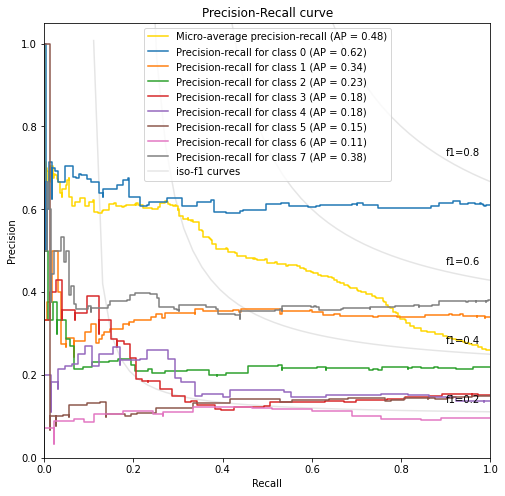

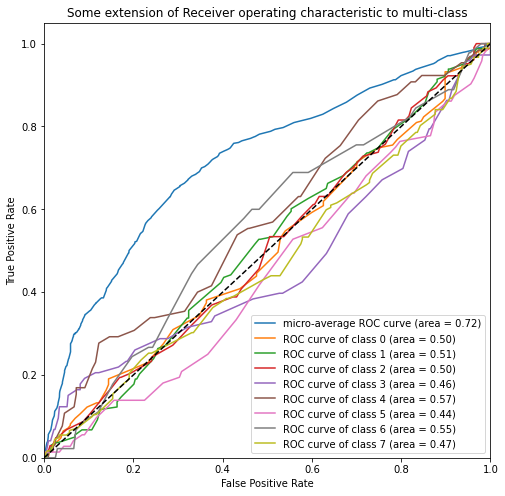

In [75]:
from skmultilearn.problem_transform import LabelPowerset

classifier = LabelPowerset(RandomForestClassifier())
classifier.fit(train_features, train_labels)

predicted_labels_lp = classifier.predict_proba(test_features)
evaluate(test_labels, predicted_labels_lp.toarray())

plot_pr_curve(test_labels, predicted_labels_lp.toarray())
plot_roc_curve(test_labels, predicted_labels_lp.toarray())